In [1]:
# Libraries import
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objs as go
#import plotly.express as px
from plotly.offline import init_notebook_mode

from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool, GeoJSONDataSource, LinearColorMapper

from googletrans import Translator

#import statsmodels.api as sn

import requests
import json

In [2]:
# Data import - 'Datos abiertos COVID-19 (Colombia)'
data = pd.DataFrame.from_dict(requests.get('https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=9999999999999').json())
#data

In [3]:
# Data import - 'World Health Organization (WHO) COVID-19 Global Data'
who_data = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
#who_data

In [4]:
# Data import - 'Colombian Departments GeoJson'
d_geojson = requests.get('https://gist.githubusercontent.com/john-guerra/43c7656821069d00dcbc/raw/be6a6e239cd5b5b803c6e7c2ec405b793a9064dd/Colombia.geo.json').json()
#d_geojson

In [5]:
# Data import - 'Colombian Towns & Cities GeoJson'
tc_geojson = requests.get('https://gist.githubusercontent.com/john-guerra/727e8992e9599b9d9f1dbfdc4c8e479e/raw/090f8b935a437e24d65b64d87598fbb437c006da/colombia-municipios.json').json()
#tc_geojson

In [6]:
# Data cleaning and adjusting
translator = Translator()
translations = {}

departments = {}
towns_cities = {}
status_counts = []

data.columns = ['Id de caso', 'Fecha de notificación', 'Código DIVIPOLA', 'Ciudad de ubicación', 'Departamento', 'Estado', 'Edad', 'Sexo', 'Tipo', 'Severidad','País de procedencia', 'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web', 'Tipo de recuperación', 'Código departamento', 'Código país', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Fecha de defunción']
#who_data.columns = ['']

for element in data['País de procedencia'].unique():
    translations[element] = translator.translate(" ".join(element.split(" ")[:2])).text if type(element) !=  float else 'Colombia'

data['País de procedencia'].replace(translations, inplace=True)

for column in ['Edad', 'Código departamento', 'Código DIVIPOLA']:
    data[column] = data[column].apply(lambda x: int(x))
    
data['Clasificación de edad'] = pd.cut(x=data['Edad'], bins=[0,10,20,30,40,50,60,70,80,90,np.inf], include_lowest=True, labels=['0 - 10', '10 - 20', '20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 100+'])

for column in ['Ciudad de ubicación', 'Estado', 'Sexo', 'Tipo', 'Severidad', 'País de procedencia']:
    data[column] = data[column].str.capitalize()
    
for column in ['Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de defunción', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web']:
    data[column] = data[column].str.slice(0,10).replace(r'(\d+)-(\d+)-(\d+)', r'\1-\2-\3', regex=True).apply(lambda x: pd.to_datetime(x, dayfirst=True, errors='ignore'))

for element in d_geojson['features']:
    departments[int(element['properties']['DPTO'])] = element['properties']['NOMBRE_DPT']
    
#for element in tc_geojson['geometries']:
#    towns_cities[int(element['id'])] = element['properties']['name']
    
status_counts = data['Estado'].value_counts().to_list()

date = data['Fecha de reporte web'].iloc[-1].strftime('%Y-%m-%d')
    
data = data[['Id de caso', 'Fecha de reporte web', 'Fecha de diagnóstico', 'Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de recuperación', 'Fecha de defunción', 'Ciudad de ubicación', 'Departamento', 'Severidad', 'Estado', 'Edad', 'Clasificación de edad', 'Sexo', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Tipo', 'Tipo de recuperación', 'País de procedencia', 'Código departamento', 'Código país', 'Código DIVIPOLA']]
data = data.set_index('Id de caso')

In [7]:
# Helper functions
def GetBars(df):
    d = df.to_dict('list')
    #for i in range(df[]):

def numbers(div): #x
    for i in range(0, len(ax.patches)//div, 1):
        height = 0
        for j in range(0, div, 1):
            height += ax.patches[j*(len(ax.patches)//div)+i].get_height()
        ax.text(ax.patches[i].get_x()+(ax.patches[i].get_width()/10),height+(height/100)+10, int(height), fontsize=7, color='dimgrey', rotation=90)

def numbers_H(div): #y
    for i in range(0, len(ax.patches)//div, 1):
        width = 0
        for j in range(0, div, 1):
            width += ax.patches[j*(len(ax.patches)//div)+i].get_width()
        ax.text(width+(width/100)+10,ax.patches[i].get_y()+(ax.patches[i].get_height()/10), int(width), fontsize=7, color='dimgrey', rotation=0)

In [8]:
# Testing
#bars = GetBars()

bar_chart = go.Figure(
    data = go.Histogram(
        
    ),
    layout = go.Layout(
        title="Casos confirmados VS Clasificación de Edad (Estado)",
        yaxis_title="Clasificación de edad",
        xaxis_title="Casos confirmados",
    )
)
#bar_chart.show()

#data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).to_dict('list')

In [9]:
#geosource = GeoJSONDataSource(geojson=json.dumps(d_geojson))

In [10]:
# In-line plots libraries import
%matplotlib inline
init_notebook_mode(connected = True)

# COVID-19 Status (Colombia) 🇨🇴

#### Fuente: <a href='https://datos.gov.co'>Datos Abiertos - Colombia</a>

### - Panorama nacional COVID-19 (Colombia)

In [11]:
local_map = go.Figure(go.Choropleth(
    z=data['Código departamento'].value_counts().sort_index().tolist(),
    locations=[departments[key] for key in sorted(departments.keys())],
    featureidkey='properties.NOMBRE_DPT',
    geojson=d_geojson,
    colorscale='blues',
    colorbar_title="Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

local_map.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds='locations')

local_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

local_map.show()

### - Dataset COVID-19 (Colombia)

In [12]:
data

Fecha de reporte web Fecha de diagnóstico Fecha de notificación  \
Id de caso                                                                   
1                    2020-03-06           2020-03-06            2020-03-02   
2                    2020-03-09           2020-03-09            2020-03-06   
3                    2020-03-09           2020-03-09            2020-03-07   
4                    2020-03-11           2020-03-11            2020-03-09   
5                    2020-03-11           2020-03-11            2020-03-09   
...                         ...                  ...                   ...   
641610               2020-09-03           2020-09-02            2020-08-22   
641611               2020-09-03           2020-09-02            2020-08-22   
641612               2020-09-03           2020-09-02            2020-08-22   
641613               2020-09-03           2020-09-02            2020-08-22   
641614               2020-09-03           2020-09-02            2020-08-22   

           Fecha de inicio de síntomas Fecha de recuperación  \
Id de caso                                                     
1                  2020-02-27 00:00:00            2020-03-13   
2                  2020-03-04 00:00:00            2020-03-19   
3                  2020-02-29 00:00:00            2020-03-15   
4                  2020-03-06 00:00:00            2020-03-26   
5                  2020-03-08 00:00:00            2020-03-23   
...                                ...                   ...   
641610             2020-08-18 00:00:00                   NaT   
641611             2020-08-18 00:00:00                   NaT   
641612             2020-08-18 00:00:00                   NaT   
641613             2020-08-18 00:00:00                   NaT   
641614             2020-08-18 00:00:00                   NaT   

           Fecha de defunción  Ciudad de ubicación     Departamento Severidad  \
Id de caso                                                                      
1                         NaT          Bogotá d.c.      Bogotá D.C.      Leve   
2                         NaT  Guadalajara de buga  Valle del Cauca      Leve   
3                         NaT             Medellín        Antioquia      Leve   
4                         NaT             Medellín        Antioquia      Leve   
5                         NaT             Medellín        Antioquia      Leve   
...                       ...                  ...              ...       ...   
641610                    NaT           Valledupar            Cesar      Leve   
641611                    NaT           Valledupar            Cesar      Leve   
641612                    NaT           Valledupar            Cesar      Leve   
641613                    NaT           Valledupar            Cesar      Leve   
641614                    NaT            Manizales           Caldas      Leve   

                Estado  ...  Clasificación de edad Sexo Pertenecia Étnica  \
Id de caso              ...                                                 
1           Recuperado  ...                10 - 20    F              Otro   
2           Recuperado  ...                30 - 40    M              Otro   
3           Recuperado  ...                40 - 50    F              Otro   
4           Recuperado  ...                50 - 60    M              Otro   
5           Recuperado  ...                20 - 30    M              Otro   
...                ...  ...                    ...  ...               ...   
641610            Casa  ...                20 - 30    M               NaN   
641611            Casa  ...                40 - 50    F               NaN   
641612            Casa  ...                30 - 40    F               NaN   
641613            Casa  ...                20 - 30    F               NaN   
641614            Casa  ...                40 - 50    F               NaN   

           Nombre Grupo Étnico         Tipo Tipo de recuperación  \
Id de caso                             

### - Casos activos VS Departamento (Estado)

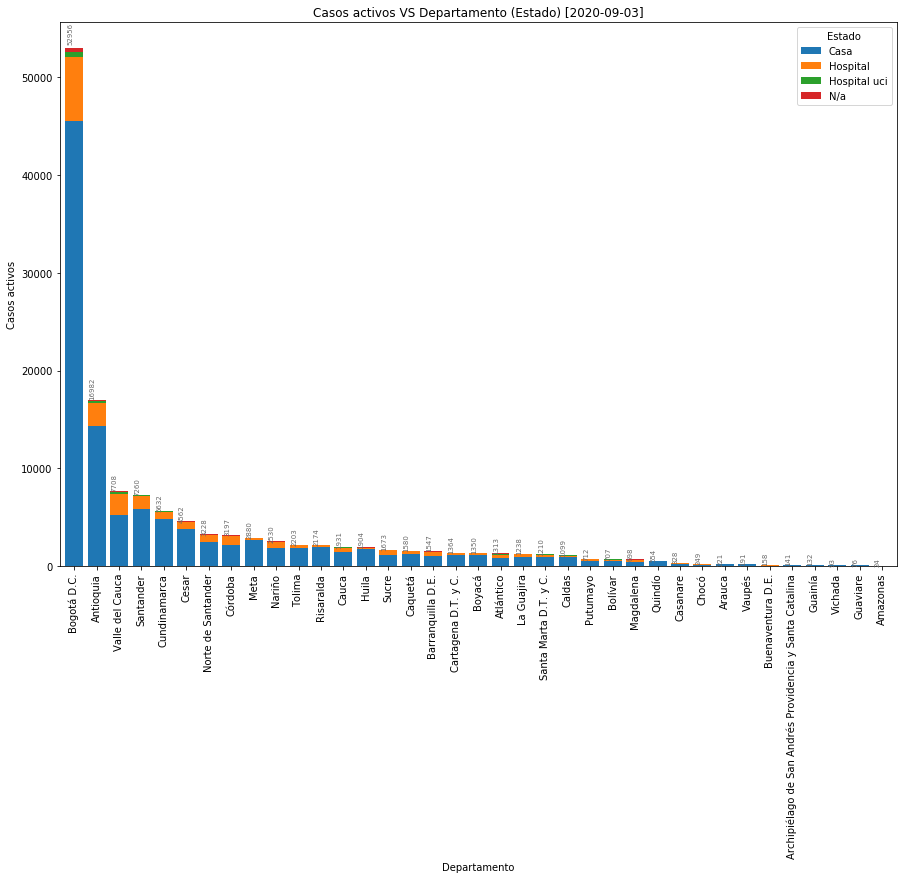

In [13]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1][::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos activos VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos activos')
div = len(li.columns)-1
numbers(div)

In [14]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Hospital  \
Departamento                                                            
Bogotá D.C.                                         45499.0    6543.0   
Antioquia                                           14287.0    2396.0   
Valle del Cauca                                      5258.0    2089.0   
Santander                                            5807.0    1362.0   
Cundinamarca                                         4825.0     749.0   
Cesar                                                3763.0     735.0   
Norte de Santander                                   2463.0     685.0   
Córdoba                                              2116.0     930.0   
Meta                                                 2646.0     206.0   
Nariño                                               1798.0     654.0   
Tolima                                               1829.0     320.0   
Risaralda                                            1901.0     251.0   
Cauca                                                1435.0     433.0   
Huila                                                1790.0      60.0   
Sucre                                                1105.0     525.0   
Caquetá                                              1248.0     307.0   
Barranquilla D.E.                                    1030.0     380.0   
Cartagena D.T. y C.                                  1097.0     193.0   
Boyacá                                               1143.0     181.0   
Atlántico                                             874.0     303.0   
La Guajira                                            950.0     254.0   
Santa Marta D.T. y C.                                 911.0     270.0   
Caldas                                                976.0     103.0   
Putumayo                                              481.0     221.0   
Bolívar                                               510.0     151.0   
Magdalena                                             458.0     186.0   
Quindío                                               501.0      50.0   
Casanare                                              257.0      64.0   
Chocó                                                  84.0     139.0   
Arauca                                                196.0      21.0   
Vaupés                                                181.0      10.0   
Buenaventura D.E.                                      42.0      92.0   
Archipiélago de San Andrés Providencia y Santa ...    129.0      11.0   
Guainía                                               130.0       2.0   
Vichada                                                92.0       1.0   
Guaviare                                               68.0       6.0   
Amazonas                                               15.0       5.0   

Estado                                              Hospital uci    N/a  \
Departamento                                                              
Bogotá D.C.                                                565.0  349.0   
Antioquia                                                  181.0  118.0   
Valle del Cauca                                            239.0  122.0   
Santander                                                   60.0   31.0   
Cundinamarca                                                26.0   32.0   
Cesar                                                       43.0   21.0   
Norte de Santander                                          59.0   21.0   
Córdoba                                                     54.0   97.0   
Meta                                                        11.0   17.0   
Nariño                                                      45.0   33.0   
Tolima                                                      23.0   31.0   
Risaralda                                                   11.0   11.0   
Cauca                                                       40.0   23.0   
Huila                      

### - Recuperados y Fallecidos VS Departamento

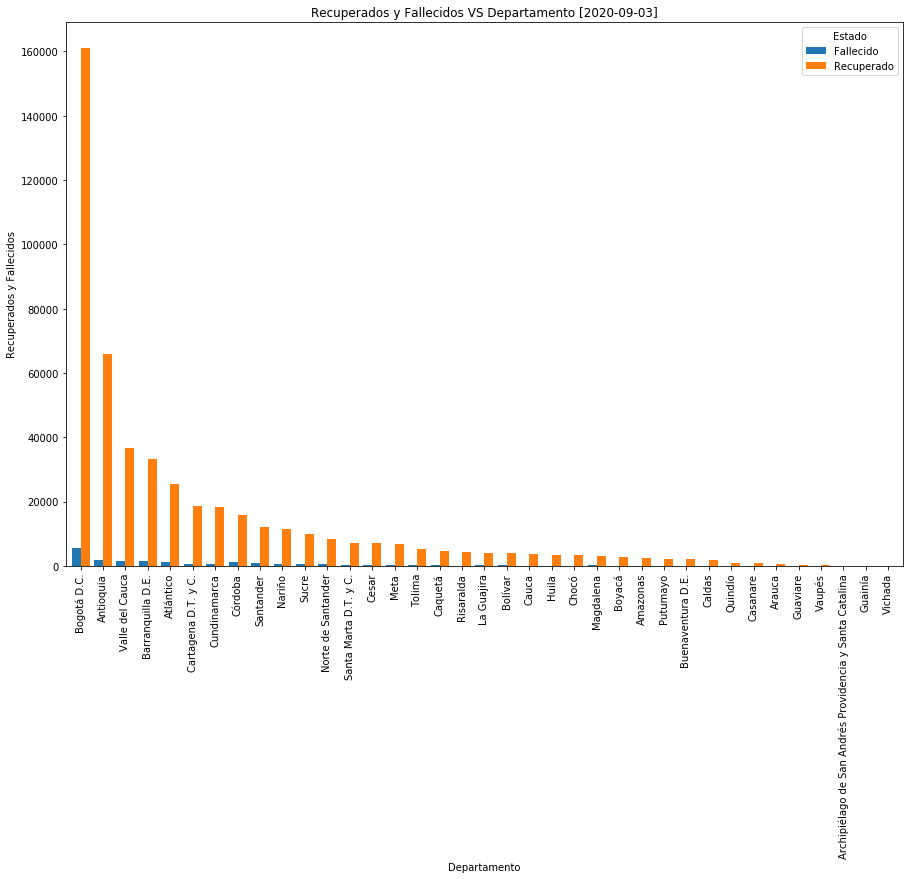

In [15]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [False, True, False, False, False, True]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=False, figsize=(15,10), title=(f'Recuperados y Fallecidos VS Departamento [{date}]'))
ax.set_ylabel('Recuperados y Fallecidos')
div = len(li.columns)-1
#numbers(div)

In [16]:
li.sort_values('Total', ascending=False).iloc[:,:len(li.columns)-1]

Estado                                              Fallecido  Recuperado
Departamento                                                             
Bogotá D.C.                                            5652.0    160976.0
Antioquia                                              1809.0     65974.0
Valle del Cauca                                        1668.0     36678.0
Barranquilla D.E.                                      1624.0     33277.0
Atlántico                                              1303.0     25632.0
Cartagena D.T. y C.                                     528.0     18805.0
Cundinamarca                                            709.0     18349.0
Córdoba                                                1357.0     15774.0
Santander                                               844.0     12254.0
Nariño                                                  549.0     11588.0
Sucre                                                   509.0      9840.0
Norte de Santander                                      691.0      8369.0
Santa Marta D.T. y C.                                   361.0      7168.0
Cesar                                                   336.0      7066.0
Meta                                                    235.0      6795.0
Tolima                                                  201.0      5306.0
Caquetá                                                 211.0      4525.0
Risaralda                                               123.0      4436.0
La Guajira                                              242.0      4043.0
Bolívar                                                 193.0      4017.0
Cauca                                                   171.0      3737.0
Huila                                                   162.0      3570.0
Chocó                                                   139.0      3374.0
Magdalena                                               339.0      3041.0
Boyacá                                                   84.0      2730.0
Amazonas                                                110.0      2570.0
Putumayo                                                141.0      2195.0
Buenaventura D.E.                                       161.0      2098.0
Caldas                                                   61.0      1992.0
Quindío                                                  43.0       836.0
Casanare                                                 26.0       793.0
Arauca                                                   19.0       755.0
Guaviare                                                  4.0       230.0
Vaupés                                                    1.0       176.0
Archipiélago de San Andrés Providencia y Santa ...        4.0       130.0
Guainía                                                   5.0        27.0
Vichada                                                   3.0        25.0

* Fallecimientos relacionados al COVID-19.

### - Casos confirmados VS Departamento (Estado)

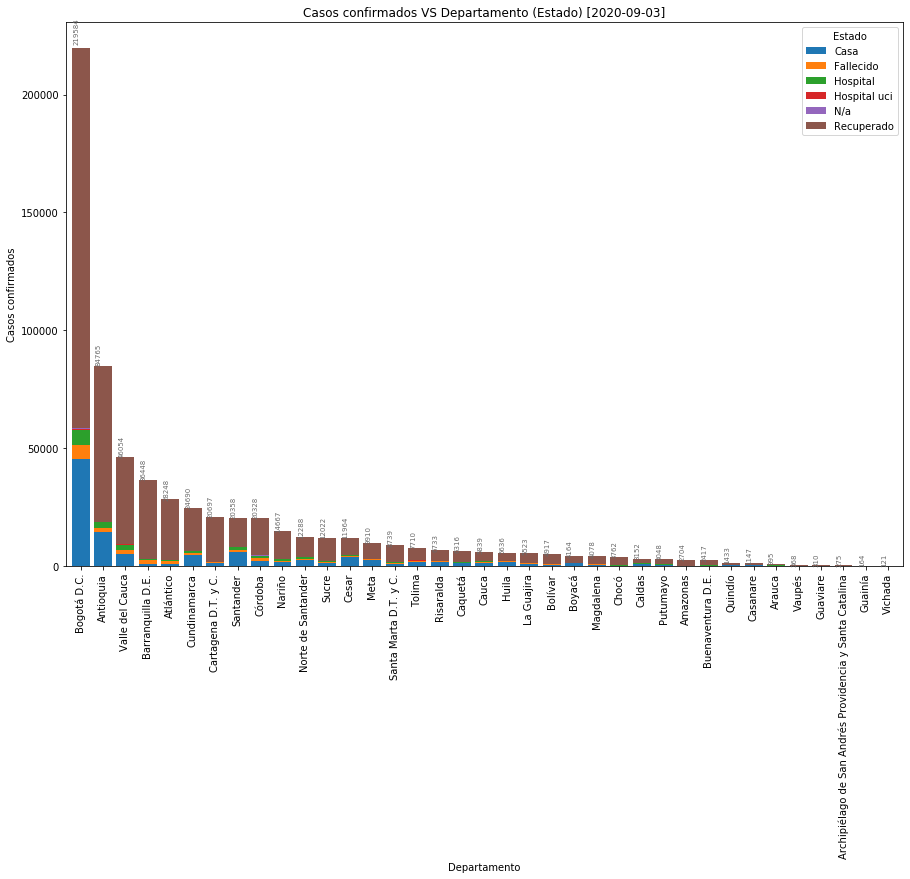

In [17]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(li.columns)-1
numbers(div)

In [18]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Fallecido  \
Departamento                                                             
Bogotá D.C.                                         45499.0     5652.0   
Antioquia                                           14287.0     1809.0   
Valle del Cauca                                      5258.0     1668.0   
Barranquilla D.E.                                    1030.0     1624.0   
Atlántico                                             874.0     1303.0   
Cundinamarca                                         4825.0      709.0   
Cartagena D.T. y C.                                  1097.0      528.0   
Santander                                            5807.0      844.0   
Córdoba                                              2116.0     1357.0   
Nariño                                               1798.0      549.0   
Norte de Santander                                   2463.0      691.0   
Sucre                                                1105.0      509.0   
Cesar                                                3763.0      336.0   
Meta                                                 2646.0      235.0   
Santa Marta D.T. y C.                                 911.0      361.0   
Tolima                                               1829.0      201.0   
Risaralda                                            1901.0      123.0   
Caquetá                                              1248.0      211.0   
Cauca                                                1435.0      171.0   
Huila                                                1790.0      162.0   
La Guajira                                            950.0      242.0   
Bolívar                                               510.0      193.0   
Boyacá                                               1143.0       84.0   
Magdalena                                             458.0      339.0   
Chocó                                                  84.0      139.0   
Caldas                                                976.0       61.0   
Putumayo                                              481.0      141.0   
Amazonas                                               15.0      110.0   
Buenaventura D.E.                                      42.0      161.0   
Quindío                                               501.0       43.0   
Casanare                                              257.0       26.0   
Arauca                                                196.0       19.0   
Vaupés                                                181.0        1.0   
Guaviare                                               68.0        4.0   
Archipiélago de San Andrés Providencia y Santa ...    129.0        4.0   
Guainía                                               130.0        5.0   
Vichada                                                92.0        3.0   

Estado                                              Hospital  Hospital uci  \
Departamento                                                                 
Bogotá D.C.                                           6543.0         565.0   
Antioquia                                             2396.0         181.0   
Valle del Cauca                                       2089.0         239.0   
Barranquilla D.E.                                      380.0          34.0   
Atlántico                                              303.0          44.0   
Cundinamarca                                           749.0          26.0   
Cartagena D.T. y C.                                    193.0          40.0   
Santander                                             1362.0          60.0   
Córdoba                                                930.0          54.0   
Nariño                                                 654.0          45.0   
Norte de Santander                                     685.0          59.0   
Sucre                                                  525.0          20.0   
Cesar                

### - Casos confirmados VS Departamento (Sexo)

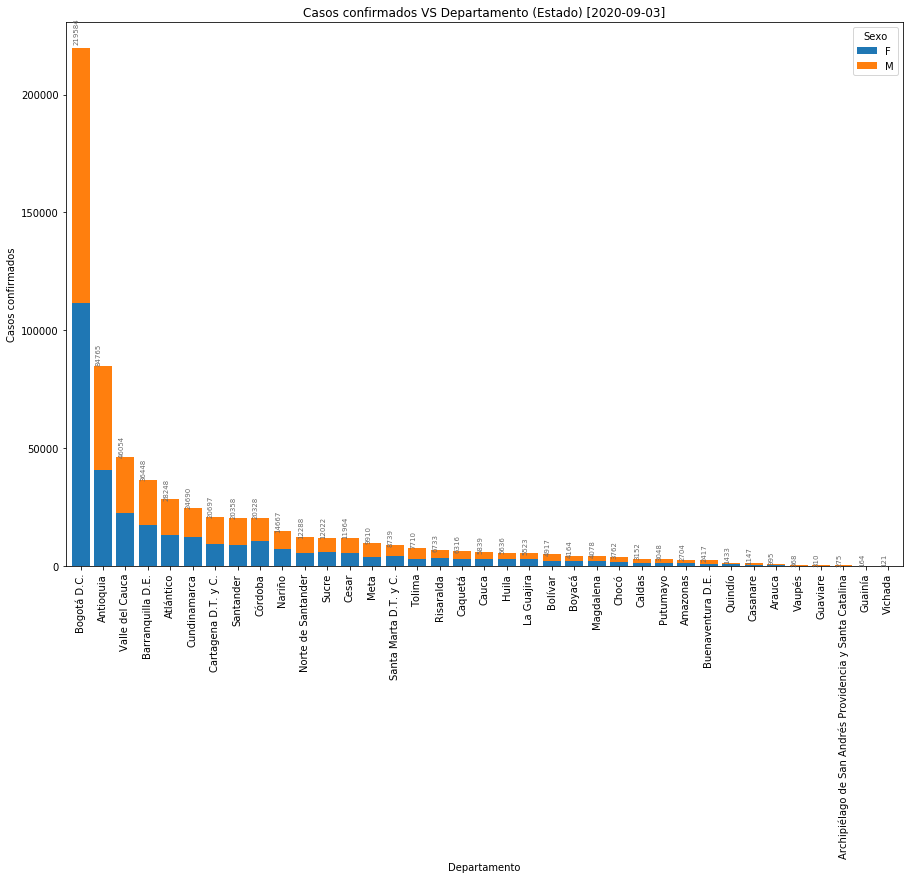

In [19]:
li = data.groupby(['Departamento', 'Sexo']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(li.columns)-1
numbers(div)

In [20]:
li.sort_values('Total', ascending=False)

Sexo                                                     F       M   Total
Departamento                                                              
Bogotá D.C.                                         111744  107840  219584
Antioquia                                            40698   44067   84765
Valle del Cauca                                      22348   23706   46054
Barranquilla D.E.                                    17207   19241   36448
Atlántico                                            13377   14871   28248
Cundinamarca                                         12527   12163   24690
Cartagena D.T. y C.                                   9564   11133   20697
Santander                                             8985   11373   20358
Córdoba                                              10471    9857   20328
Nariño                                                7076    7591   14667
Norte de Santander                                    5716    6572   12288
Sucre                                                 5867    6155   12022
Cesar                                                 5690    6274   11964
Meta                                                  3802    6108    9910
Santa Marta D.T. y C.                                 4374    4365    8739
Tolima                                                3020    4690    7710
Risaralda                                             3210    3523    6733
Caquetá                                               3124    3192    6316
Cauca                                                 2804    3035    5839
Huila                                                 2785    2851    5636
La Guajira                                            2801    2722    5523
Bolívar                                               2291    2626    4917
Boyacá                                                1947    2217    4164
Magdalena                                             2068    2010    4078
Chocó                                                 1781    1981    3762
Caldas                                                1478    1674    3152
Putumayo                                              1414    1634    3048
Amazonas                                              1165    1539    2704
Buenaventura D.E.                                      902    1515    2417
Quindío                                                709     724    1433
Casanare                                               476     671    1147
Arauca                                                 333     662     995
Vaupés                                                 154     214     368
Guaviare                                                66     244     310
Archipiélago de San Andrés Providencia y Santa ...     149     126     275
Guainía                                                 67      97     164
Vichada                                                 33      88     121

### - Mapa de influencia COVID-19 (Colombia)

In [21]:
global_map = go.Figure(data = go.Choropleth(
    z = data['País de procedencia'].value_counts().sort_index().tolist(),
    locations = sorted(data['País de procedencia'].unique().tolist()),
    locationmode = 'country names',
    colorscale = 'greens',
    colorbar_title = "Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

global_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

global_map.show()

### - Casos confirmados acumulado VS Fecha de diagnóstico (Estado)

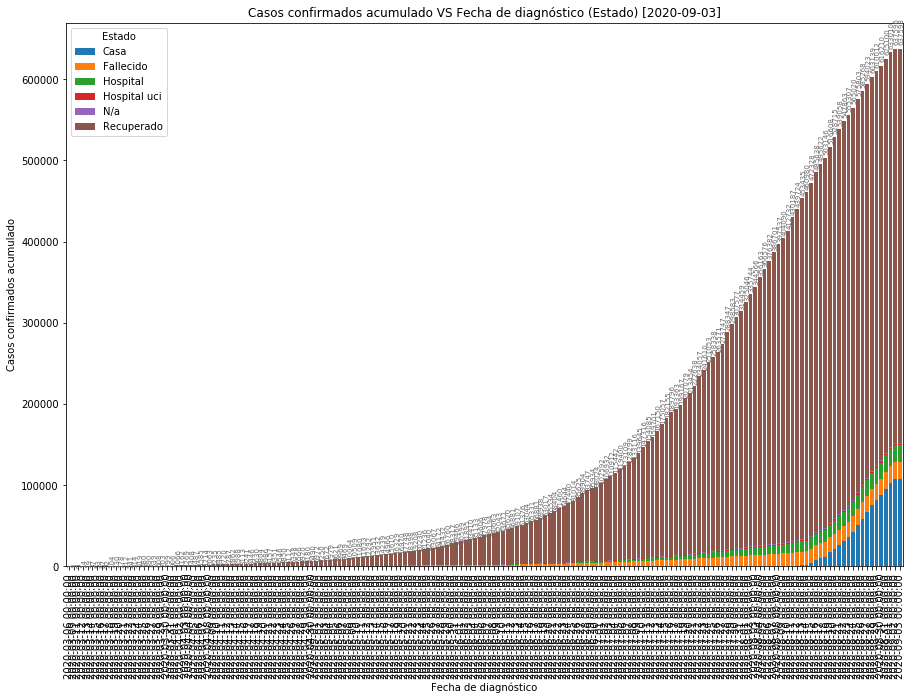

In [22]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulado VS Fecha de diagnóstico (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Estado'].unique())
numbers(div)

In [23]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Estado                    Casa  Fallecido  Hospital  Hospital uci     N/a  \
Fecha de diagnóstico                                                        
2020-09-03            107763.0    20412.0   20831.0        1677.0  1310.0   
2020-09-02            107763.0    20410.0   20831.0        1677.0  1310.0   
2020-09-01            103190.0    20408.0   20820.0        1677.0  1310.0   
2020-08-31             95610.0    20346.0   20559.0        1676.0  1310.0   
2020-08-30             87196.0    20278.0   20161.0        1675.0  1304.0   
2020-08-29             81354.0    20226.0   19870.0        1671.0  1300.0   
2020-08-28             74978.0    20130.0   19560.0        1665.0  1295.0   
2020-08-27             66746.0    20015.0   19025.0        1663.0  1293.0   
2020-08-26             58820.0    19878.0   18528.0        1662.0  1284.0   
2020-08-25             50655.0    19687.0   18011.0        1656.0  1274.0   
2020-08-24             42004.0    19524.0   17554.0        1655.0  1262.0   
2020-08-23             35509.0    19321.0   17053.0        1654.0  1247.0   
2020-08-22             30986.0    19195.0   16711.0        1652.0  1244.0   
2020-08-21             26080.0    18989.0   16277.0        1648.0  1236.0   
2020-08-20             21574.0    18761.0   15742.0        1646.0  1218.0   
2020-08-19             17538.0    18398.0   15055.0        1591.0  1203.0   
2020-08-18             11741.0    18106.0   14498.0        1551.0  1187.0   
2020-08-17             10434.0    17869.0   14161.0        1541.0  1166.0   
2020-08-16              8291.0    17693.0   13855.0        1524.0  1157.0   
2020-08-15              4022.0    17404.0   13417.0        1501.0  1148.0   
2020-08-14              1429.0    17113.0   12986.0        1485.0  1139.0   
2020-08-13              1108.0    16873.0   12700.0        1475.0  1131.0   
2020-08-12               866.0    16564.0   12228.0        1454.0  1115.0   
2020-08-11               591.0    16209.0   11823.0        1432.0  1103.0   
2020-08-10               373.0    15799.0   11213.0        1387.0  1083.0   
2020-08-09               236.0    15569.0   10896.0        1370.0  1065.0   
2020-08-08                96.0    15348.0   10618.0        1351.0  1058.0   
2020-08-07                76.0    15029.0   10347.0        1323.0  1042.0   
2020-08-06                72.0    14739.0   10038.0        1285.0  1022.0   
2020-08-05                60.0    14451.0    9785.0        1246.0  1001.0   
2020-08-04                46.0    14156.0    9471.0        1207.0   978.0   
2020-08-03                41.0    13829.0    9170.0        1169.0   962.0   
2020-08-02                36.0    13486.0    8813.0        1146.0   941.0   
2020-08-01                35.0    13119.0    8442.0        1110.0   927.0   
2020-07-31                27.0    12772.0    8009.0        1078.0   906.0   
2020-07-30                26.0    12530.0    7775.0        1060.0   890.0   
2020-07-29                22.0    12234.0    7516.0        1019.0   869.0   
2020-07-28                18.0    11934.0    7216.0         976.0   846.0   
2020-07-27                17.0    11375.0    6742.0         926.0   804.0   
2020-07-26                15.0    11046.0    6464.0         894.0   780.0   
2020-07-25                15.0    10799.0    6286.0         871.0   766.0   
2020-07-24                14.0    10494.0    5999.0         838.0   748.0   
2020-07-23                14.0    10189.0    5730.0         811.0   727.0   
2020-07-22                13.0     9812.0    5404.0         773.0   698.0   
2020-07-21                11.0     9364.0    5001.0         726.0   671.0   
2020-07-20                 9.0     9013.0    4752.0         683.0   656.0   
2020-07-19                 9.0     8739.0    4477.0         655.0   644.0   
2020-07-18                 9.0     8456.0    4269.0         633.0   627.0   
2020-07-17                 9.0     8213.0    4103.0         606.0   605.0   
2020-07-16                 9.0     8036.0    4009.0         592.0   596.0

### - Casos confirmados VS Fecha de diagnóstico (Estado)

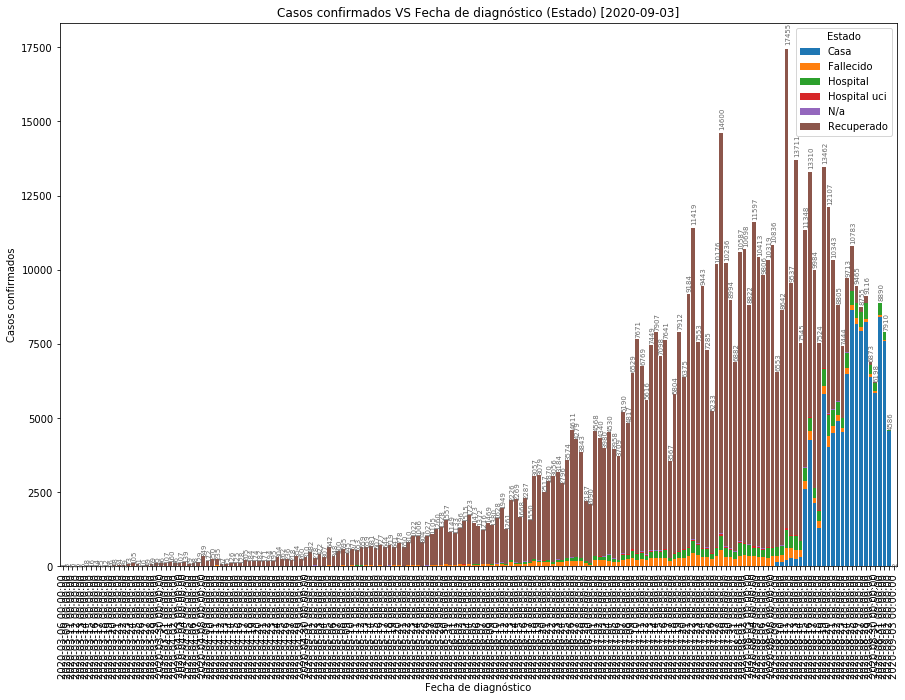

In [24]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers(div)

In [25]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).tail(60)[::-1]

Estado                  Casa  Fallecido  Hospital  Hospital uci   N/a  \
Fecha de diagnóstico                                                    
2020-09-03               0.0        2.0       0.0           0.0   0.0   
2020-09-02            4573.0        2.0      11.0           0.0   0.0   
2020-09-01            7580.0       62.0     261.0           1.0   0.0   
2020-08-31            8414.0       68.0     398.0           1.0   6.0   
2020-08-30            5842.0       52.0     291.0           4.0   4.0   
2020-08-29            6376.0       96.0     310.0           6.0   5.0   
2020-08-28            8232.0      115.0     535.0           2.0   2.0   
2020-08-27            7926.0      137.0     497.0           1.0   9.0   
2020-08-26            8165.0      191.0     517.0           6.0  10.0   
2020-08-25            8651.0      163.0     457.0           1.0  12.0   
2020-08-24            6495.0      203.0     501.0           1.0  15.0   
2020-08-23            4523.0      126.0     342.0           2.0   3.0   
2020-08-22            4906.0      206.0     434.0           4.0   8.0   
2020-08-21            4506.0      228.0     535.0           2.0  18.0   
2020-08-20            4036.0      363.0     687.0          55.0  15.0   
2020-08-19            5797.0      292.0     557.0          40.0  16.0   
2020-08-18            1307.0      237.0     337.0          10.0  21.0   
2020-08-17            2143.0      176.0     306.0          17.0   9.0   
2020-08-16            4269.0      289.0     438.0          23.0   9.0   
2020-08-15            2593.0      291.0     431.0          16.0   9.0   
2020-08-14             321.0      240.0     286.0          10.0   8.0   
2020-08-13             242.0      309.0     472.0          21.0  16.0   
2020-08-12             275.0      355.0     405.0          22.0  12.0   
2020-08-11             218.0      410.0     610.0          45.0  20.0   
2020-08-10             137.0      230.0     317.0          17.0  18.0   
2020-08-09             140.0      221.0     278.0          19.0   7.0   
2020-08-08              20.0      319.0     271.0          28.0  16.0   
2020-08-07               4.0      290.0     309.0          38.0  20.0   
2020-08-06              12.0      288.0     253.0          39.0  21.0   
2020-08-05              14.0      295.0     314.0          39.0  23.0   
2020-08-04               5.0      327.0     301.0          38.0  16.0   
2020-08-03               5.0      343.0     357.0          23.0  21.0   
2020-08-02               1.0      367.0     371.0          36.0  14.0   
2020-08-01               8.0      347.0     433.0          32.0  21.0   
2020-07-31               1.0      242.0     234.0          18.0  16.0   
2020-07-30               4.0      296.0     259.0          41.0  21.0   
2020-07-29               4.0      300.0     300.0          43.0  23.0   
2020-07-28               1.0      559.0     474.0          50.0  42.0   
2020-07-27               2.0      329.0     278.0          32.0  24.0   
2020-07-26               0.0      247.0     178.0          23.0  14.0   
2020-07-25               1.0      305.0     287.0          33.0  18.0   
2020-07-24               0.0      305.0     269.0          27.0  21.0   
2020-07-23               1.0      377.0     326.0          38.0  29.0   
2020-07-22               2.0      448.0     403.0          47.0  27.0   
2020-07-21               2.0      351.0     249.0          43.0  15.0   
2020-07-20               0.0      274.0     275.0          28.0  12.0   
2020-07-19               0.0      283.0     208.0          22.0  17.0   
2020-07-18               0.0      243.0     166.0          27.0  22.0   
2020-07-17               0.0      177.0      94.0          14.0   9.0   
2020-07-16               1.0      287.0     250.0          36.0  20.0   
2020-07-15               0.0      296.0     200.0          30.0  11.0   
2020-07-14               0.0      287.0     212.0          28.0  26.0   
2020-07-13               0.0      269.0     226.0         

### - Casos confirmados VS Clasificación de edad (Estado)

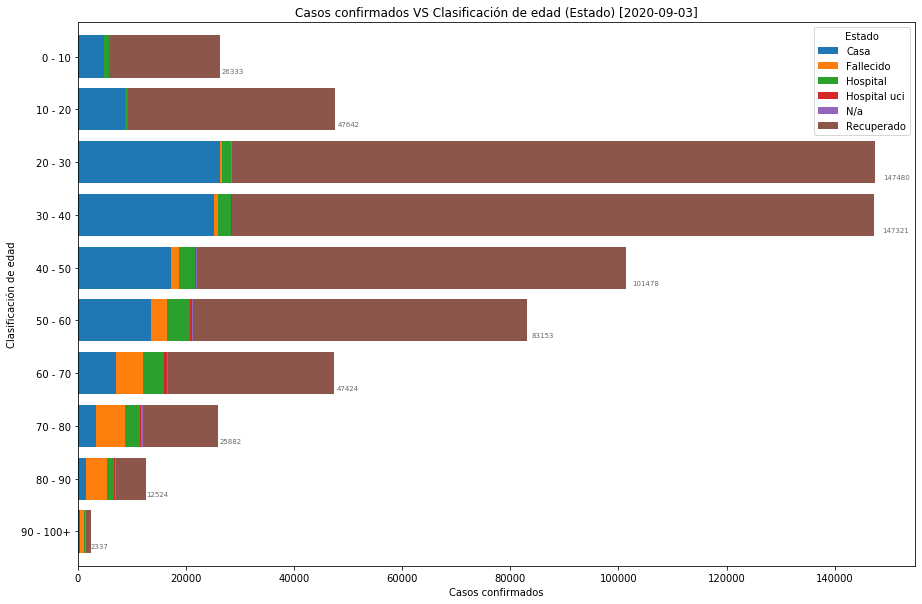

In [26]:
ax = data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Clasificación de edad (Estado) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers_H(div)

In [27]:
data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0)

Estado                  Casa  Fallecido  Hospital  Hospital uci  N/a  \
Clasificación de edad                                                  
0 - 10                  4733         35       901            38   32   
10 - 20                 8751         33       434            26   24   
20 - 30                26332        262      1697            72   58   
30 - 40                25196        673      2493           175   50   
40 - 50                17166       1497      2953           265  100   
50 - 60                13448       3089      4224           425  159   
60 - 70                 7047       4960      3983           408  276   
70 - 80                 3401       5289      2725           228  315   
80 - 90                 1522       3901      1304            46  257   
90 - 100+                299        879       174             5   63   

Estado                 Recuperado  
Clasificación de edad              
0 - 10                      20594  
10 - 20                     38374  
20 - 30                    119059  
30 - 40                    118734  
40 - 50                     79497  
50 - 60                     61808  
60 - 70                     30750  
70 - 80                     13924  
80 - 90                      5494  
90 - 100+                     917

### - Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)

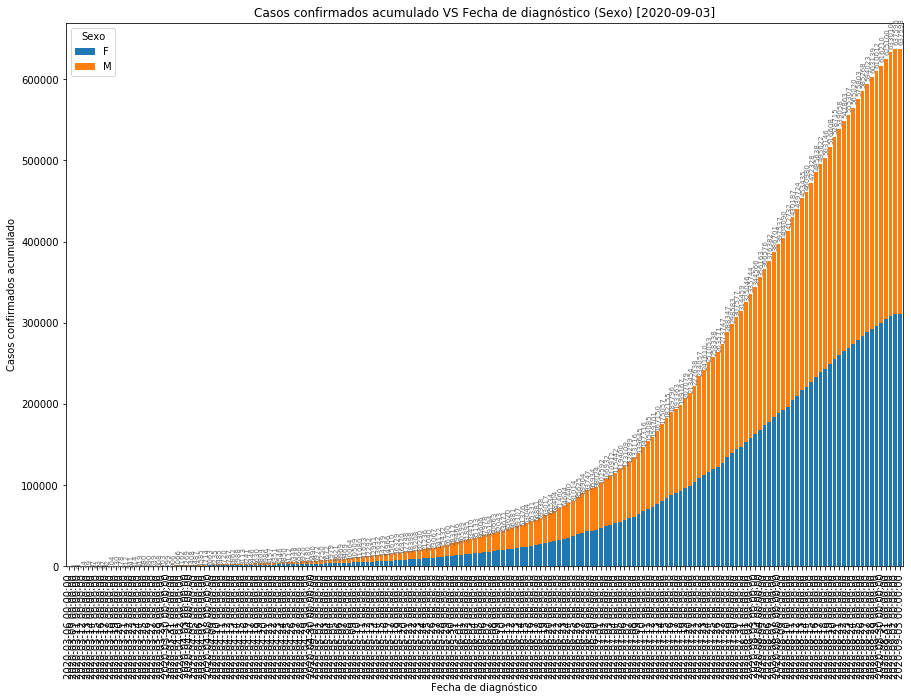

In [28]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulado VS Fecha de diagnóstico (Sexo) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Sexo'].unique())
numbers(div)

In [29]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Sexo                         F         M
Fecha de diagnóstico                    
2020-09-03            310331.0  327267.0
2020-09-02            310329.0  327267.0
2020-09-01            307993.0  325017.0
2020-08-31            304058.0  321042.0
2020-08-30            299377.0  316833.0
2020-08-29            296226.0  313786.0
2020-08-28            292743.0  310396.0
2020-08-27            288147.0  305876.0
2020-08-26            283749.0  301519.0
2020-08-25            278923.0  296880.0
2020-08-24            273510.0  291510.0
2020-08-23            268654.0  286653.0
2020-08-22            264885.0  282978.0
2020-08-21            260732.0  278326.0
2020-08-20            255521.0  273194.0
2020-08-19            249422.0  267186.0
2020-08-18            242432.0  260714.0
2020-08-17            238803.0  256819.0
2020-08-16            233527.0  252111.0
2020-08-15            226571.0  245757.0
2020-08-14            220804.0  240176.0
2020-08-13            216940.0  236495.0
2020-08-12            210077.0  229647.0
2020-08-11            205349.0  224838.0
2020-08-10            196302.0  216430.0
2020-08-09            191963.0  212127.0
2020-08-08            188586.0  208951.0
2020-08-07            183313.0  203388.0
2020-08-06            178274.0  198108.0
2020-08-05            173417.0  193159.0
2020-08-04            168208.0  187955.0
2020-08-03            162393.0  182173.0
2020-08-02            158129.0  177615.0
2020-08-01            152661.0  172385.0
2020-07-31            147538.0  166921.0
2020-07-30            144088.0  163489.0
2020-07-29            139711.0  158872.0
2020-07-28            134639.0  153708.0
2020-07-27            127533.0  146214.0
2020-07-26            122663.0  140908.0
2020-07-25            120266.0  138072.0
2020-07-24            116589.0  134464.0
2020-07-23            112221.0  129389.0
2020-07-22            108654.0  125403.0
2020-07-21            103493.0  119145.0
2020-07-20             99198.0  114256.0
2020-07-19             96223.0  110856.0
2020-07-18             92438.0  106729.0
2020-07-17             89662.0  103701.0
2020-07-16             87903.0  101893.0
2020-07-15             84159.0   97996.0
2020-07-14             80798.0   94259.0
2020-07-13             77199.0   89951.0
2020-07-12             73632.0   86069.0
2020-07-11             70960.0   83125.0
2020-07-10             67742.0   79574.0
2020-07-09             64241.0   75404.0
2020-07-08             61279.0   71837.0
2020-07-07             58968.0   69331.0
2020-07-06             56562.0   66547.0

### - Casos confirmados VS Fecha de diagnóstico (Sexo)

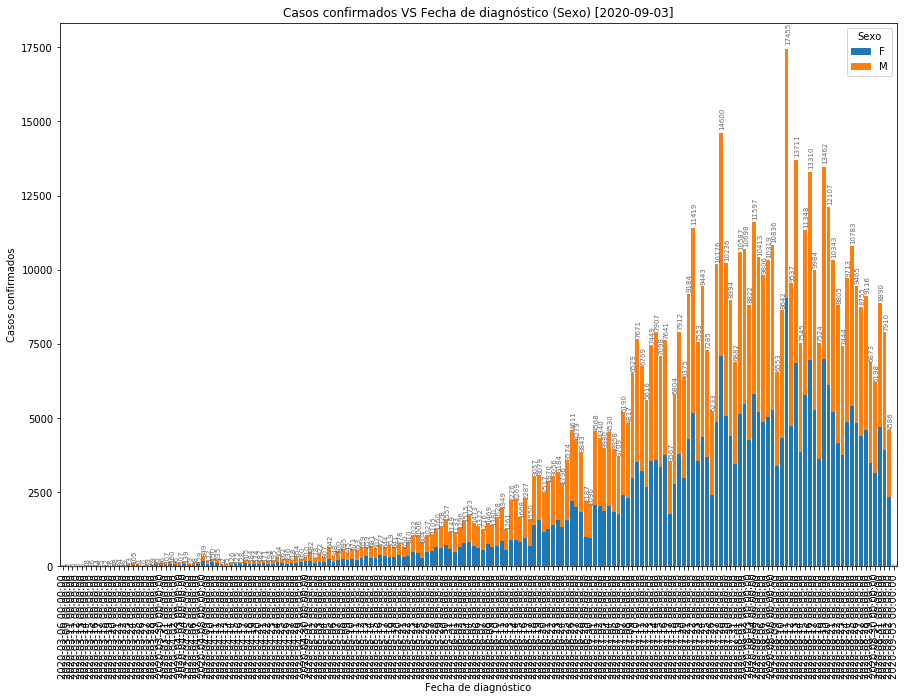

In [30]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Sexo) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers(div)

In [31]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).tail(60)[::-1]

Sexo                       F       M
Fecha de diagnóstico                
2020-09-03               2.0     0.0
2020-09-02            2336.0  2250.0
2020-09-01            3935.0  3975.0
2020-08-31            4681.0  4209.0
2020-08-30            3151.0  3047.0
2020-08-29            3483.0  3390.0
2020-08-28            4596.0  4520.0
2020-08-27            4398.0  4357.0
2020-08-26            4826.0  4639.0
2020-08-25            5413.0  5370.0
2020-08-24            4856.0  4857.0
2020-08-23            3769.0  3675.0
2020-08-22            4153.0  4652.0
2020-08-21            5211.0  5132.0
2020-08-20            6099.0  6008.0
2020-08-19            6990.0  6472.0
2020-08-18            3629.0  3895.0
2020-08-17            5276.0  4708.0
2020-08-16            6956.0  6354.0
2020-08-15            5767.0  5581.0
2020-08-14            3864.0  3681.0
2020-08-13            6863.0  6848.0
2020-08-12            4728.0  4809.0
2020-08-11            9047.0  8408.0
2020-08-10            4339.0  4303.0
2020-08-09            3377.0  3176.0
2020-08-08            5273.0  5563.0
2020-08-07            5039.0  5280.0
2020-08-06            4857.0  4949.0
2020-08-05            5209.0  5204.0
2020-08-04            5815.0  5782.0
2020-08-03            4264.0  4558.0
2020-08-02            5468.0  5230.0
2020-08-01            5123.0  5464.0
2020-07-31            3450.0  3432.0
2020-07-30            4377.0  4617.0
2020-07-29            5072.0  5164.0
2020-07-28            7106.0  7494.0
2020-07-27            4870.0  5306.0
2020-07-26            2397.0  2836.0
2020-07-25            3677.0  3608.0
2020-07-24            4368.0  5075.0
2020-07-23            3567.0  3986.0
2020-07-22            5161.0  6258.0
2020-07-21            4295.0  4889.0
2020-07-20            2975.0  3400.0
2020-07-19            3785.0  4127.0
2020-07-18            2776.0  3028.0
2020-07-17            1759.0  1808.0
2020-07-16            3744.0  3897.0
2020-07-15            3361.0  3737.0
2020-07-14            3599.0  4308.0
2020-07-13            3567.0  3882.0
2020-07-12            2672.0  2944.0
2020-07-11            3218.0  3551.0
2020-07-10            3501.0  4170.0
2020-07-09            2962.0  3567.0
2020-07-08            2311.0  2506.0
2020-07-07            2406.0  2784.0
2020-07-06            1752.0  1957.0

### - Casos confirmados VS Clasificación de edad (Sexo)

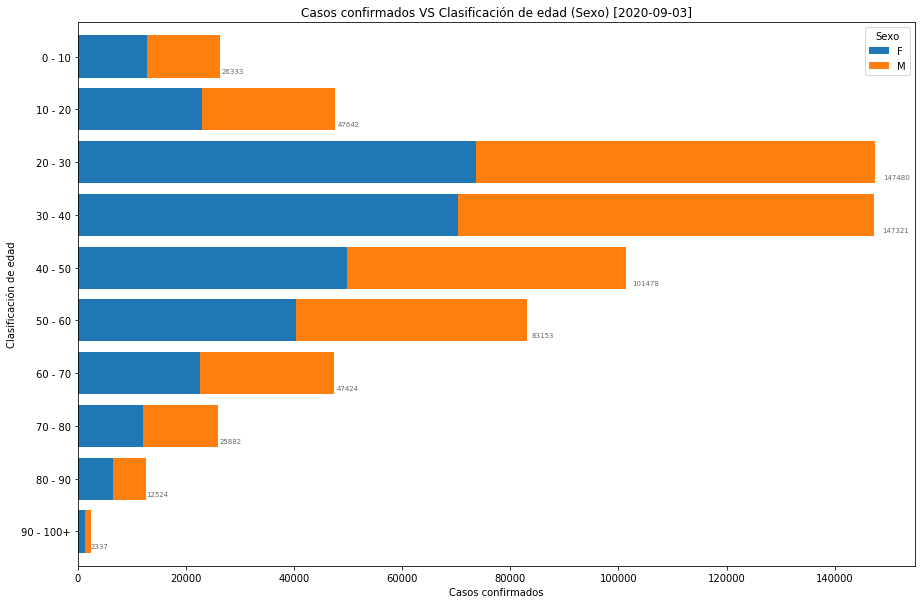

In [32]:
ax = data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Clasificación de edad (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [33]:
data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0)

Sexo                       F      M
Clasificación de edad              
0 - 10                 12839  13494
10 - 20                22950  24692
20 - 30                73608  73872
30 - 40                70351  76970
40 - 50                49744  51734
50 - 60                40318  42835
60 - 70                22610  24814
70 - 80                12075  13807
80 - 90                 6406   6118
90 - 100+               1322   1015

### - Casos confirmados VS Estado (Sexo)

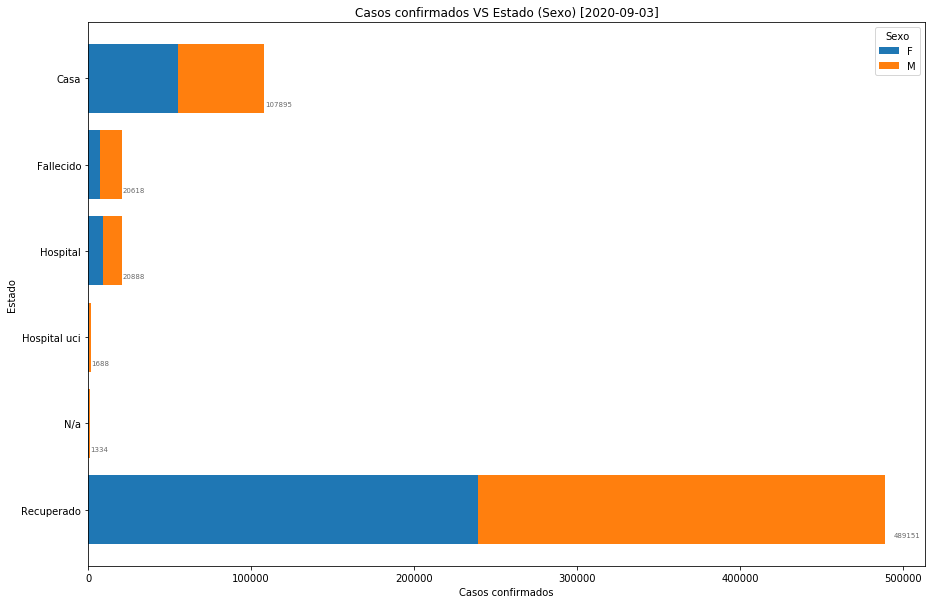

In [34]:
ax = data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Estado (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [35]:
data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0)

Sexo               F       M
Estado                      
Casa           55268   52627
Fallecido       7388   13230
Hospital        8878   12010
Hospital uci     580    1108
N/a              574     760
Recuperado    239535  249616

### - Casos confirmados VS Tipo de contagio (Sexo)

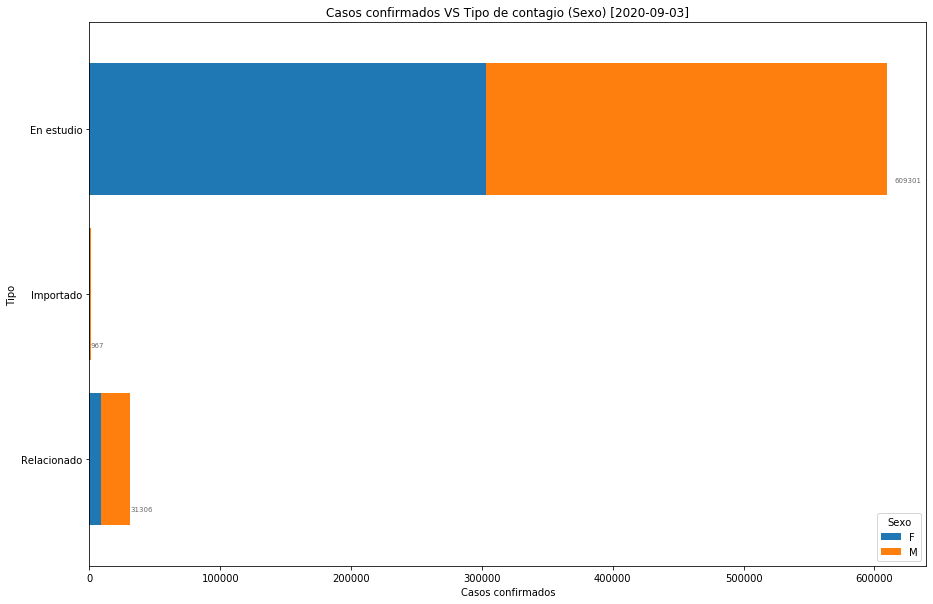

In [36]:
ax = data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Tipo de contagio (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [37]:
data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0)

Sexo              F       M
Tipo                       
En estudio   302991  306310
Importado       456     511
Relacionado    8776   22530

### - Casos confirmados acumulado VS Fecha de diagnóstico (Clasificación de edad)

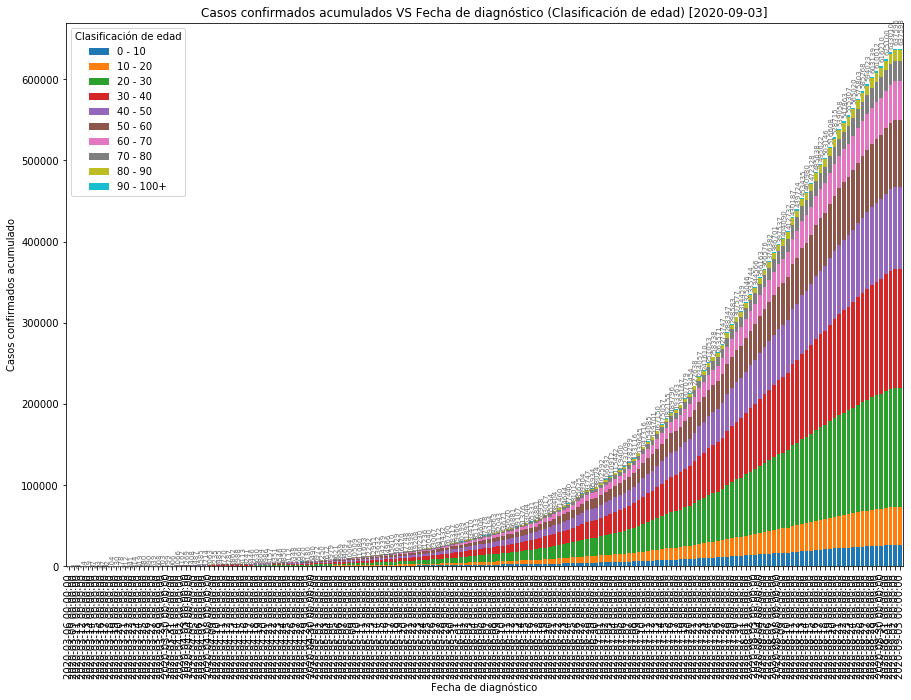

In [38]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulados VS Fecha de diagnóstico (Clasificación de edad) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [39]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-09-03              26194    47356   146516   146365   100890    82669   
2020-09-02              26194    47356   146516   146365   100890    82669   
2020-09-01              25993    47039   145505   145420   100178    82039   
2020-08-31              25663    46410   143696   143648    98973    80996   
2020-08-30              25264    45723   141574   141680    97568    79901   
2020-08-29              25022    45254   140107   140286    96597    79105   
2020-08-28              24772    44730   138498   138777    95537    78162   
2020-08-27              24450    44112   136455   136636    94106    76939   
2020-08-26              24106    43479   134415   134628    92714    75817   
2020-08-25              23757    42768   132376   132475    91182    74636   
2020-08-24              23367    42071   129931   129938    89436    73196   
2020-08-23              23003    41356   127671   127758    87916    71937   
2020-08-22              22693    40753   125895   126023    86816    70956   
2020-08-21              22372    40093   123863   123927    85494    69842   
2020-08-20              21950    39345   121401   121571    83861    68490   
2020-08-19              21465    38487   118741   118852    81936    66875   
2020-08-18              20837    37503   115712   115836    79722    65176   
2020-08-17              20583    36989   114034   114140    78522    64147   
2020-08-16              20069    36228   111822   112040    76929    62809   
2020-08-15              19451    35091   108860   109141    74810    61059   
2020-08-14              18951    34252   106246   106633    73023    59532   
2020-08-13              18698    33706   104517   104956    71806    58470   
2020-08-12              18075    32642   101413   101852    69615    56665   
2020-08-11              17727    32005    99326    99644    68099    55400   
2020-08-10              16932    30751    95207    95606    65261    53150   
2020-08-09              16601    30070    93256    93599    63907    52034   
2020-08-08              16357    29643    91748    92170    62825    51150   
2020-08-07              15940    28859    89308    89525    61119    49729   
2020-08-06              15526    28088    86948    87091    59479    48393   
2020-08-05              15077    27343    84768    84850    57909    47119   
2020-08-04              14650    26617    82381    82438    56221    45753   
2020-08-03              14161    25799    79723    79727    54318    44169   
2020-08-02              13837    25190    77723    77676    52971    42951   
2020-08-01              13394    24470    75312    75281    51164    41450   
2020-07-31              12980    23614    72757    72772    49543    40103   
2020-07-30              12707    23156    71227    71135    48368    39253   
2020-07-29              12363    22443    69045    69003    47041    38077   
2020-07-28              11981    21697    66619    66528    45355    36832   
2020-07-27              11352    20560    63294    63240    43038    34899   
2020-07-26              10966    19838    60906    60855    41368    33686   
2020-07-25              10756    19513    59717    59628    40554    33005   
2020-07-24              10472    19029    58080    57924    39388    32014   
2020-07-23              10151    18308    55875    55635    37911    30780   
2020-07-22               9874    17792    54191    53887    36710    29789   
2020-07-21               9468    16944    51469    51298    34924    28244   
2020-07-20               9108    16317    49304    49117    33440    27092   
2020-07-19               8830    15857    47949    47657    32370    26263   
2020-07-18               8517    15197    46115    45801    31060    25281   
2020-07-17               8295    14855    44821    44385    30103    24529   
2020-07-16            

### - Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)

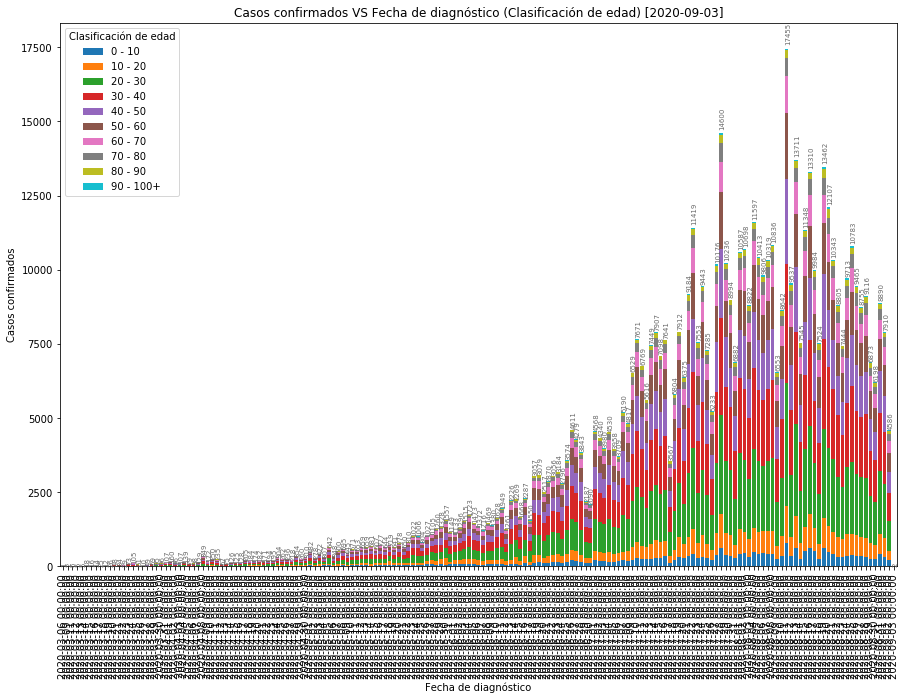

In [40]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Clasificación de edad) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [41]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-09-03                  0        0        0        0        0        0   
2020-09-02                201      317     1011      945      712      630   
2020-09-01                330      629     1809     1772     1205     1043   
2020-08-31                399      687     2122     1968     1405     1095   
2020-08-30                242      469     1467     1394      971      796   
2020-08-29                250      524     1609     1509     1060      943   
2020-08-28                322      618     2043     2141     1431     1223   
2020-08-27                344      633     2040     2008     1392     1122   
2020-08-26                349      711     2039     2153     1532     1181   
2020-08-25                390      697     2445     2537     1746     1440   
2020-08-24                364      715     2260     2180     1520     1259   
2020-08-23                310      603     1776     1735     1100      981   
2020-08-22                321      660     2032     2096     1322     1114   
2020-08-21                422      748     2462     2356     1633     1352   
2020-08-20                485      858     2660     2719     1925     1615   
2020-08-19                628      984     3029     3016     2214     1699   
2020-08-18                254      514     1678     1696     1200     1029   
2020-08-17                514      761     2212     2100     1593     1338   
2020-08-16                618     1137     2962     2899     2119     1750   
2020-08-15                500      839     2614     2508     1787     1527   
2020-08-14                253      546     1729     1677     1217     1062   
2020-08-13                623     1064     3104     3104     2191     1805   
2020-08-12                348      637     2087     2208     1516     1265   
2020-08-11                795     1254     4119     4038     2838     2250   
2020-08-10                331      681     1951     2007     1354     1116   
2020-08-09                244      427     1508     1429     1082      884   
2020-08-08                417      784     2440     2645     1706     1421   
2020-08-07                414      771     2360     2434     1640     1336   
2020-08-06                449      745     2180     2241     1570     1274   
2020-08-05                427      726     2387     2412     1688     1366   
2020-08-04                489      818     2658     2711     1903     1584   
2020-08-03                324      609     2000     2051     1347     1218   
2020-08-02                443      720     2411     2395     1807     1501   
2020-08-01                414      856     2555     2509     1621     1347   
2020-07-31                273      458     1530     1637     1175      850   
2020-07-30                344      713     2182     2132     1327     1176   
2020-07-29                382      746     2426     2475     1686     1245   
2020-07-28                629     1137     3325     3288     2317     1933   
2020-07-27                386      722     2388     2385     1670     1213   
2020-07-26                210      325     1189     1227      814      681   
2020-07-25                284      484     1637     1704     1166      991   
2020-07-24                321      721     2205     2289     1477     1234   
2020-07-23                277      516     1684     1748     1201      991   
2020-07-22                406      848     2722     2589     1786     1545   
2020-07-21                360      627     2165     2181     1484     1152   
2020-07-20                278      460     1355     1460     1070      829   
2020-07-19                313      660     1834     1856     1310      982   
2020-07-18                222      342     1294     1416      957      752   
2020-07-17                123      219      802      861      547      454   
2020-07-16            

### - Casos confirmados VS Estado (Clasificación de edad)

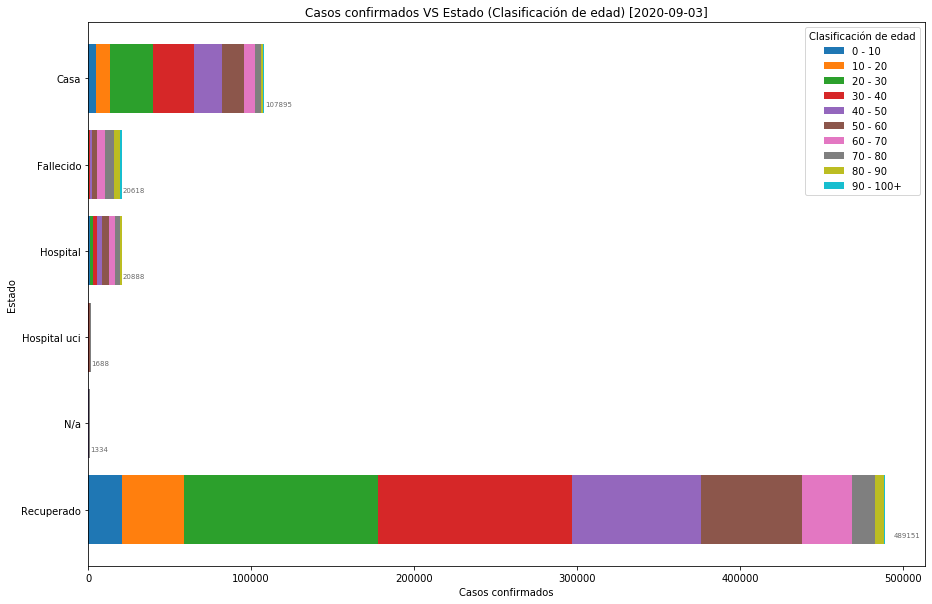

In [42]:
ax = data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Estado (Clasificación de edad) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [43]:
data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Estado                                                                       
Casa                     4733     8751    26332    25196    17166    13448   
Fallecido                  35       33      262      673     1497     3089   
Hospital                  901      434     1697     2493     2953     4224   
Hospital uci               38       26       72      175      265      425   
N/a                        32       24       58       50      100      159   
Recuperado              20594    38374   119059   118734    79497    61808   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Estado                                                       
Casa                      7047     3401     1522        299  
Fallecido                 4960     5289     3901        879  
Hospital                  3983     2725     1304        174  
Hospital uci               408      228       46          5  
N/a                        276      315      257         63  
Recuperado               30750    13924     5494        917

### - Casos confirmados VS Tipo de contagio (Clasificación de edad)

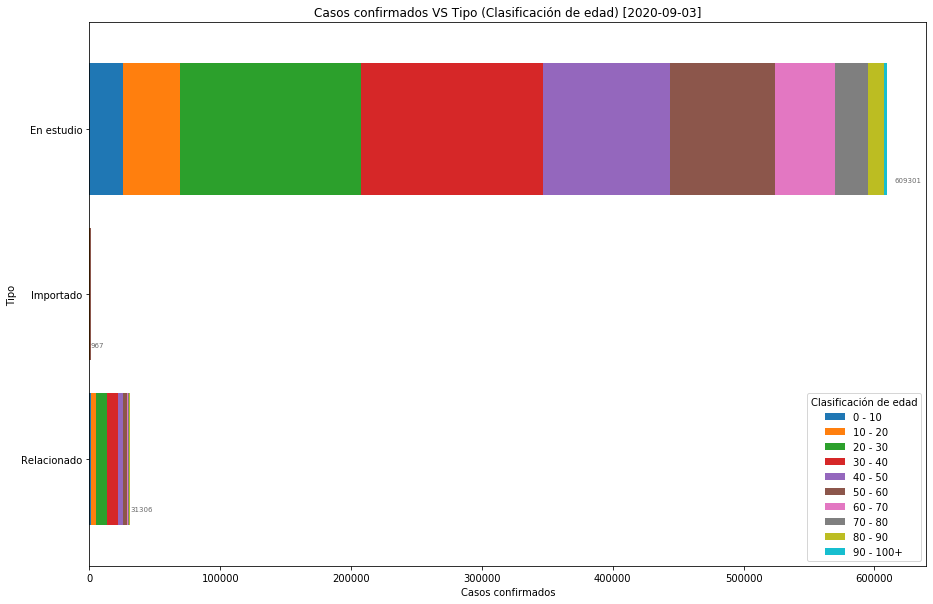

In [44]:
ax = data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Tipo (Clasificación de edad) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [45]:
data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Tipo                                                                         
En estudio              25308    43762   138496   139035    97334    80286   
Importado                   6       37      239      223      172      144   
Relacionado              1019     3843     8745     8063     3972     2723   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Tipo                                                         
En estudio               45877    25094    11933       2176  
Importado                   98       37       10          1  
Relacionado               1449      751      581        160

## Y para los curiosos... 👀

### - Casos activos VS Ciudad de ubicación (Estado) [TOP 50]

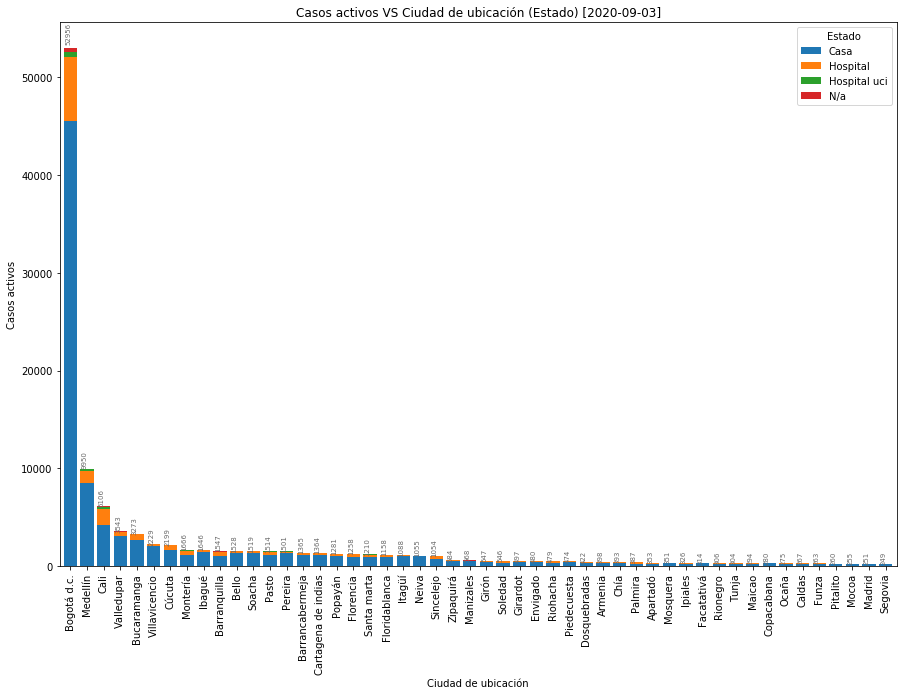

In [46]:
li = data.groupby(['Ciudad de ubicación', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').tail(50).iloc[:,:len(li.columns)-1][::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos activos VS Ciudad de ubicación (Estado) [{date}]'))
ax.set_ylabel('Casos activos')
div = len(li.columns)-1
numbers(div)

In [47]:
li.sort_values('Total', ascending=False).head(50)

Estado                  Casa  Hospital  Hospital uci    N/a    Total
Ciudad de ubicación                                                 
Bogotá d.c.          45499.0    6543.0         565.0  349.0  52956.0
Medellín              8460.0    1308.0         121.0   61.0   9950.0
Cali                  4227.0    1580.0         207.0   92.0   6106.0
Valledupar            3058.0     448.0          27.0   10.0   3543.0
Bucaramanga           2682.0     557.0          21.0   13.0   3273.0
Villavicencio         2074.0     134.0           9.0   12.0   2229.0
Cúcuta                1670.0     475.0          42.0   12.0   2199.0
Montería              1118.0     472.0          30.0   46.0   1666.0
Ibagué                1441.0     176.0          10.0   19.0   1646.0
Barranquilla          1030.0     380.0          34.0  103.0   1547.0
Bello                 1330.0     180.0          13.0    5.0   1528.0
Soacha                1298.0     207.0           7.0    7.0   1519.0
Pasto                 1111.0     364.0          24.0   15.0   1514.0
Pereira               1318.0     168.0           7.0    8.0   1501.0
Barrancabermeja       1154.0     201.0           7.0    3.0   1365.0
Cartagena de indias   1097.0     193.0          40.0   34.0   1364.0
Popayán               1040.0     217.0          14.0   10.0   1281.0
Florencia              968.0     273.0          10.0    7.0   1258.0
Santa marta            911.0     270.0          11.0   18.0   1210.0
Floridablanca          886.0     254.0          13.0    5.0   1158.0
Itagüí                 983.0      98.0           2.0    5.0   1088.0
Neiva                  979.0      41.0          28.0    7.0   1055.0
Sincelejo              688.0     340.0          12.0   14.0   1054.0
Zipaquirá              542.0      38.0           1.0    3.0    584.0
Manizales              524.0      36.0           2.0    6.0    568.0
Girón                  418.0     120.0           6.0    3.0    547.0
Soledad                292.0     194.0          18.0   42.0    546.0
Girardot               432.0      65.0           0.0    0.0    497.0
Envigado               422.0      50.0           6.0    2.0    480.0
Riohacha               358.0     108.0           7.0    6.0    479.0
Piedecuesta            373.0      96.0           5.0    0.0    474.0
Dosquebradas           362.0      57.0           2.0    1.0    422.0
Armenia                355.0      40.0           2.0    1.0    398.0
Chía                   353.0      37.0           0.0    3.0    393.0
Palmira                228.0     142.0          10.0    7.0    387.0
Apartadó               234.0     109.0           5.0    5.0    353.0
Mosquera               307.0      36.0           6.0    2.0    351.0
Ipiales                209.0     111.0           3.0    3.0    326.0
Facatativá             261.0      50.0           3.0    0.0    314.0
Rionegro               250.0      52.0           2.0    2.0    306.0
Tunja                  255.0      37.0           6.0    6.0    304.0
Maicao                 204.0      73.0          16.0    1.0    294.0
Copacabana             263.0      14.0           1.0    2.0    280.0
Ocaña                  194.0      76.0           4.0    1.0    275.0
Caldas                 246.0      21.0           0.0    0.0    267.0
Funza                  211.0      50.0           2.0    0.0    263.0
Pitalito               246.0       9.0           2.0    3.0    260.0
Mocoa                  203.0      52.0           0.0    0.0    255.0
Madrid                 219.0      30.0           1.0    1.0    251.0
Segovia                240.0       7.0           2.0    0.0    249.0

## #StayHome 🏠 #QuédateEnCasa
## #WearMask 😷 #UsaMascarilla 

### Creado con ❤️ por <a href='https://github.com/jlcadavid'>@jlcadavid</a>

In [48]:
# Data storage
data.to_csv(f'./Datasets/COVID-19 Status (Colombia) [{date}].csv', index = True)